In [1]:
import numpy as np

    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

from RKHS import Gram

%load_ext autoreload
%autoreload 2

In [2]:
def h(r,c,l):
    return c * np.exp(-(r**2) / l**2)

# The differentiable kernel function with parameters c,l not filled.

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(np.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,np.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*np.log(np.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*np.log(np.linalg.det(KA))

In [3]:
def marginal_gain(x_new,x_old,kernel):
    '''
        Calculate the marginal gain in mutual information, given x_old has been collected, and a list of candidate x_new's is to be collected.
        
        x_old.shape = (t,space_dim)
        
        x_new.shape = (n,space_dim)
        
        Output: shape = (n), output[i] = marginal gain for x_new[i].
    '''
    
    S = Gram(kernel,x_old)

    k_t = kernel(x_new[:,np.newaxis,:],x_old).T



    return 1/2*np.log(1 + c/var_0 \
                   - 1/var_0**2 *np.sum(k_t.T.dot(np.linalg.inv(\
                                np.eye(len(S))+1/var_0 * S))* k_t.T,axis=-1))

In [7]:
def incremental_greedy(kernel,x0,step_size,ref,R,T):
    xs = [x0]

    n_test = 2 * 10 ** 5

    for _ in range(T-1):
        # Generate the feasible random samples
        rand_theta = np.random.rand(n_test)*2*np.pi

        rand_dir = np.array([np.cos(rand_theta),np.sin(rand_theta)])

        x_test = xs[-1]+(step_size*np.random.rand(n_test)*rand_dir).T # Step size constraint.

        x_test = x_test[(np.linalg.norm(x_test[:,np.newaxis,:]-ref,axis=-1)<=R).ravel()] # Bounded region constraint.

        gain = marginal_gain(x_test,np.array(xs),kernel)

        x_best = x_test[np.argmax(gain)]

        xs.append(x_best)
    return np.array(xs)

In [4]:
c = 1
l = 1
var_0 = 0.01

step_size = 1

T = 19

kernel = partial(k,c=c,l=l)
objective = partial(GPMI,c=c,l=l,var_0=var_0)


search_region_center = np.array([0.,0.])
search_region_radius = 3

ref = np.array([0,0])

R = search_region_radius

In [8]:
x0 = np.array([0,0])
    
xs = incremental_greedy(kernel,x0,step_size,ref,R,T)

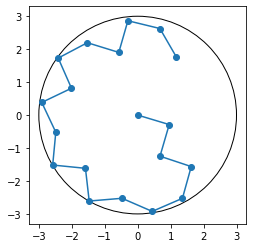

In [9]:
xs = np.array(xs)
plt.plot(xs[:,0],xs[:,1],marker='o')
circ = plt.Circle(ref,R,fill=False)
plt.gca().add_patch(circ)
plt.gca().set_aspect('equal')

In [10]:
objective(xs)

4.2504576696396505e+01